# AcousticBrainz Genre Task 2017: Content-based music genre recognition from multiple sources

In [1]:
# Nice graphs for high dpi screens
%config InlineBackend.figure_format = 'retina'

## Install and import packages

In [2]:
!pip install -U scikit-learn[alldeps]
!pip install -U python-dotenv
!pip install -U pandas
!pip install nbstripout
!pip install nbformat


Requirement already up-to-date: scikit-learn[alldeps] in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: numpy>=1.6.1; extra == "alldeps" in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from scikit-learn[alldeps])
Requirement already up-to-date: scipy>=0.9; extra == "alldeps" in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from scikit-learn[alldeps])
Requirement already up-to-date: python-dotenv in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: click>=5.0 in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from python-dotenv)
Requirement already up-to-date: pandas in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: numpy>=1.7.0 in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages

You **must** restart the kernel after first instaling or updating packages!

In [3]:
from sklearn import svm
import pandas as pd
import numpy as np
import json


In [72]:
%run Utilities.ipynb
%run Evaluation.ipynb

## Load groundtruth and filter available records
During development it is very likely the notebook is executed with a subset of the training data, because the training data is very large (approx 80 GiB). Therefore it is needed to filter out any records we don't want to use in this notebook.

In [5]:
# Read tsv file into groundtruth and extract only id and main genre from it
groundtruth = load_groundtruth(settings['path'] + 'groundtruth/acousticbrainz-mediaeval2017-tagtraum-train.tsv')

print 'Groundtruth size: %d' % len(groundtruth)
print 'Found {} unique genres.'.format(len(groundtruth['genre1'].unique()))


Groundtruth size: 61315
Found 31 unique genres.


### Only run for manual sampling method

# Create better balanced training data
By using a fixed number of recordings of each genre for training, the classifier will be better balanced. And this will hopefully remove bias to a genre that is in the dataset many times.

## Select records with a single main genre and no sub genres

In [73]:
import matplotlib.pyplot as plt


single_genre = groundtruth[groundtruth['genre2'].isnull()]
count_per_genre = single_genre[['genre1', 'main_genres']].groupby(['genre1']).count()
sample_size = count_per_genre['main_genres'].quantile(0.5)

balanced_groundtruth = pd.DataFrame()

for genre, count in count_per_genre.iterrows():
    specific_genre_groundtruth = single_genre[single_genre['genre1'] == genre]
    
    if count[0] > sample_size:
        specific_genre_groundtruth = specific_genre_groundtruth.sample(n=int(sample_size))
        
    balanced_groundtruth = balanced_groundtruth.append(specific_genre_groundtruth)

# Shuffle balanced_groundtruth
balanced_groundtruth = balanced_groundtruth.sample(frac=1)
# Load training data
balanced_training_data = balanced_groundtruth['recordingmbid'].apply(getOnlyUsedFeatures)

print 'Groundtruth size: %d' % len(balanced_groundtruth)


Groundtruth size: 2049


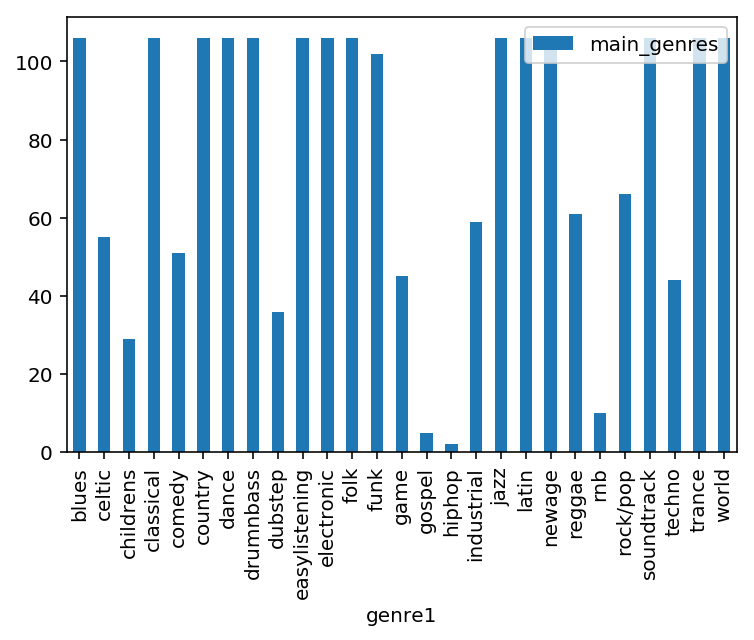

In [74]:
balanced_groundtruth[['genre1', 'main_genres']] \
    .groupby(['genre1']) \
    .count() \
    .plot.bar()

plt.show()


In [75]:

single_main_genre = groundtruth[groundtruth.apply(lambda x: len(x['main_genres']) == 1, axis=1)]

count_per_main_genre = single_main_genre[['genre1', 'main_genres']].groupby(['genre1']).count()
balanced_groundtruth_main_genre = pd.DataFrame()

sample_size_main_genre = 200

for genre, count in count_per_main_genre.iterrows():
    specific_main_genre_groundtruth = single_main_genre[single_main_genre['genre1'] == genre]
    
    if count[0] > sample_size_main_genre:
        specific_main_genre_groundtruth = specific_main_genre_groundtruth.sample(n=int(sample_size_main_genre))
    
    balanced_groundtruth_main_genre = balanced_groundtruth_main_genre.append(specific_main_genre_groundtruth)

# Shuffle balanced_groundtruth
balanced_groundtruth_main_genre = balanced_groundtruth_main_genre.sample(frac=1)
# Load training data
balanced_main_genre_training_data = balanced_groundtruth_main_genre['recordingmbid'].apply(getOnlyUsedFeatures)

print 'Groundtruth size: %d' % len(balanced_main_genre_training_data)

Groundtruth size: 4955


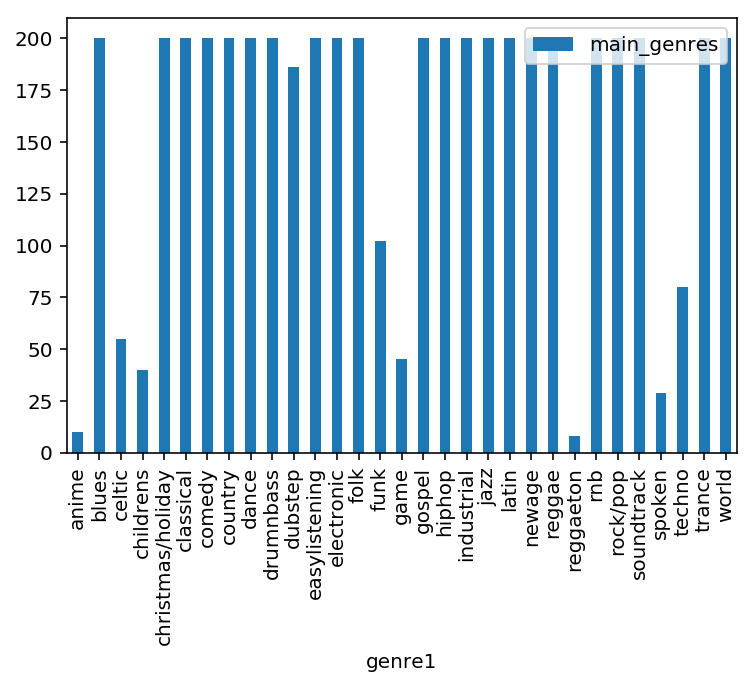

In [76]:

balanced_groundtruth_main_genre[['genre1', 'main_genres']] \
    .groupby(['genre1']) \
    .count() \
    .plot.bar()

plt.show()


In [77]:
unique_genres = set(groundtruth['genre1'])
new_groundtruth = pd.DataFrame()

for genre in unique_genres:
    sampling_groundtruth = groundtruth.loc[groundtruth['genre1'] == genre]
    if (len(sampling_groundtruth) < 300):
        sampling_groundtruth = sampling_groundtruth     
    else:
        sampling_groundtruth = sampling_groundtruth.sample(n=300)
    
    new_groundtruth = new_groundtruth.append(sampling_groundtruth)
    

7917


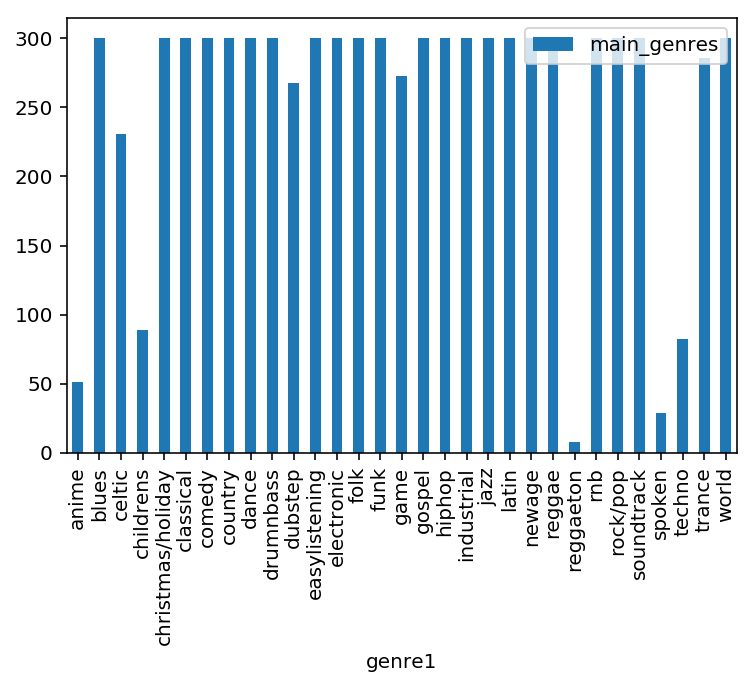

In [78]:
new_groundtruth
print len(new_groundtruth)


new_groundtruth[['genre1', 'main_genres']] \
    .groupby(['genre1']) \
    .count() \
    .plot.bar()

plt.show()



In [16]:
# Maybe during development you want a really really small dataset ?
if settings['very_few'] == 'True':
    print 'Limit groundtruth to 10000 elements'
    groundtruth = groundtruth.head(1000)
    new_groundtruth = new_groundtruth[0:1000]
 

In [79]:
training_data = groundtruth['recordingmbid'].apply(getOnlyUsedFeatures)

print training_data.head()

            0           1          2          3         4          5   \
5  -660.139587  121.530540   5.697535  13.327252  5.021361  11.331622   
13 -679.603271  125.228378  35.483788  29.039871  5.262113  14.113679   
36 -645.969238  165.192169 -40.472145  32.391174  3.760951  20.606869   
46 -701.899475  121.766136  -3.262742  39.391304  6.836935  12.013849   
49 -718.165771   91.628433   0.323307  18.404621 -4.719338  11.764834   

           6         7         8         9         10        11        12  \
5    6.837637  5.910365  2.455761  3.847580  0.393639  1.414631 -0.724385   
13   2.200374  2.936115 -2.847207 -3.056014 -2.138968 -1.003430 -1.244201   
36  -0.952870  2.843954  4.736265  5.066277  0.049501  3.451734  2.520769   
46   1.056020  7.222706  8.112492 -1.480092 -4.448884 -2.150205 -0.124595   
49  10.448994  5.367526 -0.087811  0.503982  2.646261  5.923469  1.392516   

          13        14  
5   0.827227  0.037254  
13  0.869614  0.035631  
36  0.934392  0.056531 

## Train SVM

In [80]:
from sklearn.multiclass import OneVsRestClassifier


def do_experiment(classifier, data, labels):
    separation = int(len(data) * 0.9)
    
    training_data = data[0:separation]
    training_labels = labels[0:separation]
    
    test_data = data[separation:]
    test_labels = labels[separation:]
    
    return do_experiment_separate_training_data(classifier, 
                                                training_data, training_labels, 
                                                test_data, test_labels)

def do_experiment_separate_training_data(classifier, training_data, training_labels, test_data, test_labels):
    
    classifier.fit(training_data, training_labels)

    predictions = classifier.predict(test_data)    
    test_truth = test_labels.apply(lambda x: [x])
    
    evaluation_results = evaluate(predictions, test_truth)

    display(evaluation_results[0])
    display(evaluation_results[1])
    
    return evaluation_results, predictions

In [81]:
# Balance dataset with only a single genre
%run Evaluation.ipynb

clf = OneVsRestClassifier(svm.SVC(kernel='rbf', class_weight='balanced'))

results_OvsR_SVC = do_experiment(clf, 
                                 balanced_training_data, 
                                 balanced_groundtruth['genre1'])


,correct,total,accuracy
total,8,205,3.9


,total,classified,other,wrong,diff
folk,14,0,0,0,14
blues,14,0,0,0,14
world,13,0,0,0,13
easylistening,12,0,0,0,12
latin,12,0,0,0,12
electronic,12,0,0,0,12
techno,11,0,0,0,11
drumnbass,10,0,0,0,10
funk,10,0,0,0,10
trance,10,0,0,0,10


In [96]:
# Balanced dataset with a single main genre but possible sub genres

clf = OneVsRestClassifier(svm.SVC(kernel='rbf'))
print len(balanced_main_genre_training_data)
results_OvsR_SVC = do_experiment(clf, 
                                 balanced_main_genre_training_data, 
                                 balanced_groundtruth_main_genre['genre1'])

4955


,correct,total,accuracy
total,13,496,2.62


,total,classified,other,wrong,diff
christmas/holiday,31,1,0,0,30
dance,27,0,0,0,27
blues,26,0,0,0,26
easylistening,26,0,0,0,26
hiphop,24,0,0,0,24
newage,23,0,0,0,23
world,23,0,0,0,23
folk,22,0,0,0,22
classical,21,0,0,0,21
rnb,20,0,0,0,20


In [86]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

results_GaussianNB = do_experiment(model_GaussianNB, 
                                   balanced_training_data, 
                                   balanced_groundtruth['genre1'])


,correct,total,accuracy
total,34,205,16.59


,total,classified,other,wrong,diff
folk,14,2,0,11,12
blues,14,1,0,0,13
world,13,0,0,0,13
latin,12,0,0,3,12
easylistening,12,5,0,11,7
electronic,12,1,0,8,11
techno,11,0,0,1,11
funk,10,5,0,27,5
trance,10,3,0,22,7
drumnbass,10,1,0,4,9


In [87]:
results_GaussianNB = do_experiment(model_GaussianNB, 
                                   balanced_main_genre_training_data, 
                                   balanced_groundtruth_main_genre['genre1'])



,correct,total,accuracy
total,88,496,17.74


,total,classified,other,wrong,diff
christmas/holiday,31,2,0,3,29
dance,27,6,0,16,21
easylistening,26,5,0,14,21
blues,26,1,0,6,25
hiphop,24,3,0,6,21
world,23,0,0,5,23
newage,23,0,0,2,23
folk,22,7,0,13,15
classical,21,11,0,36,10
trance,20,12,0,45,8


## Undersampling using imbalance dataset library

In [20]:
from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

In [101]:
RANDOM_STATE = None
pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), neighbors.KNeighborsClassifier(20))

In [100]:
results_smote_knn = do_experiment(pipeline, 
                                 training_data, 
                                 groundtruth['genre1'])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


,correct,total,accuracy
total,2902,6132,47.33


,total,classified,other,wrong,diff
rock/pop,2775,2487,0,2127,288
electronic,408,28,0,111,380
jazz,360,94,0,229,266
hiphop,324,74,0,152,250
dance,308,64,0,164,244
soundtrack,247,68,0,170,179
rnb,229,7,0,21,222
country,220,8,0,29,212
folk,167,5,0,5,162
blues,160,5,0,9,155


In [94]:
# pipeline_svc = make_pipeline(NearMiss(version=2, random_state=RANDOM_STATE),
#                          LinearSVC(random_state=RANDOM_STATE))
pipeline_svc = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                          LinearSVC(random_state=RANDOM_STATE))

In [95]:
results_smote_svc = do_experiment(pipeline_svc, 
                                 training_data, 
                                 groundtruth['genre1'])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


,correct,total,accuracy
total,2638,6132,43.02


,total,classified,other,wrong,diff
rock/pop,2775,2635,0,2891,140
electronic,408,0,0,0,408
jazz,360,1,0,5,359
hiphop,324,0,0,0,324
dance,308,1,0,3,307
soundtrack,247,0,0,0,247
rnb,229,0,0,0,229
country,220,0,0,0,220
folk,167,0,0,0,167
blues,160,0,0,0,160


In [ ]:
#using different approach to split data
X_train, X_test, y_train, y_test = train_test_split(training_data, groundtruth['genre1'],
                                                     random_state=RANDOM_STATE)

# Create a pipeline
# pipeline = make_pipeline(NearMiss(version=2, random_state=RANDOM_STATE),
#                          LinearSVC(random_state=RANDOM_STATE))
pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), neighbors.KNeighborsClassifier(3))
pipeline.fit(X_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(groundtruth['genre1'][-5000:], pipeline.predict(training_data[-5000:])))

## Using Manual Sampling

In [46]:
# Load training data sample 300
new_training_data = new_groundtruth['recordingmbid'].apply(getOnlyUsedFeatures)

In [47]:
clf = OneVsRestClassifier(svm.SVC(kernel='rbf', class_weight='balanced'))
clf.fit(new_training_data, new_groundtruth['genre1'])

results = do_experiment(clf, new_training_data, new_groundtruth['genre1'])

,correct,total,accuracy
total,0,792,0.0


,total,classified,other,wrong,diff
gospel,300,0,0,0,300
christmas/holiday,300,0,0,0,300
rock/pop,141,0,0,0,141
anime,51,0,0,0,51
newage,0,0,0,654,0
latin,0,0,0,14,0
game,0,0,0,1,0
trance,0,0,0,1,0
folk,0,0,0,5,0
easylistening,0,0,0,8,0
